# Machine learning for medicine
## Basic Linear Regression: Finding lines that explain our data
Authors: Vineet Tiruvadi, Alex Milani, Avinash Murugan




## License
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.


## Overview
'Linear regression' is a fancy way of saying we're going to see how two things we care about relate to each other with a straight line.
Linear regression is the workhorse of much of the statistics we learn, especially the statistics in 'evidence-based medicine' courses taught in medical school.

![](https://vineet.tiruvadi.com/egg_basic_LR.png)

A simple (silly) example is in the figure above: we cooked 100 eggs for different amounts of time and rated their deliciousness.
We built a linear regression model (blue line) that does a good job of 'fitting' our data and, importantly, 'summarized' our results - more cooking = more delicious.

**The red line is the "true" relationship and it looks like our line might start being wrong if we cook for much longer than 5 minutes...**
Linear regression has several major limitations which modern ML does a fantastic job of accounting for.
We'll cover these in later notebooks.

*Disclaimer: Data in this notebook is **simulated** because the focus of these notebooks is on the tools to use, not on the data its used on. Using simulated data means we can actually compare the 'results' of our machine learning to the 'truth' that we used to simulate our data*


Outline:
* Code setup
* A 2-dimensional linear regression
* See how effect size affects the regression
* A 3-dimensional linear regression

### Code Setup

In [0]:
# The big library for doing math + data in python
import numpy as np
np.random.seed(1111)

# A big library that has a lot of useful functions for scientific use of python
import scipy

# The main library for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [20, 15]

# The main library used for statistics
import scipy.stats as stats

# Libraries that let us use interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Misc stuff related to cleaning up code and displaying results in a pretty way
from IPython.display import Markdown as md

# The library we're going to use for our linear regression
from sklearn.linear_model import LinearRegression

# SPLIT
truth = lambda x,slope: slope * x
# TODO RANDOM SEED FIXED

#### General Functions
def gen_lin_data(factor,noise,samples):
    x = np.random.uniform(-10,10,size=(samples,)).reshape(-1,1)
    y = truth(x,factor) + np.random.normal(0,noise,size=x.shape)
    
    return x,y

def simple_eg(slope=1.0,noise=0.0,samples=100):
    x,y = gen_lin_data(slope,noise,samples)
    #x = np.random.uniform(-10,10,size=(samples,))
    #y = slope * x + np.random.normal(0,noise,size=x.shape)

    reg = LinearRegression(fit_intercept=False).fit(x, y)
    reg.score(exp_1_a1c, exp_1_lrcv)
    slope_estimate = reg.coef_[0,0]

    plt.figure()
    plt.scatter(x,y)
    #plt.scatter(x,np.random.normal(0,noise,size=x.shape),color='red',alpha=0.4)
    x_fix = np.linspace(-10,10,100)
    plt.plot(x_fix,slope * x_fix,'--',label='True')
    plt.plot(x_fix,slope_estimate * x_fix + reg.intercept_,label='Regression')
    #plt.text(3,80,'Estimated slope: ' + str(np.round(slope_estimate,4)),color='red')

    plt.legend()

    plt.ylim(-30,30)
    plt.xlim(-30,30)
    plt.axis('off')

    plt.title('Regression slope is ' + str(reg.coef_[0,0]))
    plt.suptitle('True slope is ' + str(slope))
  
    #corr_val = stats.pearsonr(x,y)
    #plt.text(2,-10,s='Pearson: ' + str(corr_val[0]) + '\n p=' + str(corr_val[1]))
    plt.show()


In [0]:
# Simulated Data

In [0]:
# Plotting

In [0]:
def plot_data(a1c,bgluc):
    plt.figure()
    plt.scatter(a1c,bgluc)
    plt.xlabel('Measured A1c')
    plt.ylabel('Lifetime risk of CV disease')
    plt.xlim((0,15))
    plt.ylim((0,100));

## Background
As physicians, we care about healthy physiology and how diseases break that physiology.
Physiology is a fancy word for "how parts of the body affect each other"

One of the basic tools we have in studying how things relate to each other is 'lines'.
Linear regression is a fancy way of saying: let's find lines between variables that tell us how they affect each, and its a major workhorse in statistics.
A lot of EBM statistics are 
Linear regressions are a major workhorse in statistics.
A lot of the statistics we learn in EBM is derived from a linear regression model.

What we're doing here is opening up the hood of EBM.
This notebook lays the groundwork for understanding more advanced concepts in machine learning.

## Linear Regression (2D)
Let's learn linear regression around an example.

We know diabetes is bad.
We know patients with diabetes tend to have more lifelong complications, especially with their cardiovascular system.
We also know that the severity of the diabetes is related to the Hemoglobin A1c, a measure of the 'average' glucose concentration in the blood over the last few months.

Let's try to find this relationship between the A1c and lifetime risk of cardiovascular disease.


First, for this exercise, we defined the *truth*: that the blood glucose is just the A1c times a *conversion factor* which is $\frac{100}{6} \approx 16.6667$

Next, we're going to *simulate* a study with a certain number of patients.

Let's see what the data from the experiment looks like:

Regression slope is 3.1130232086766134


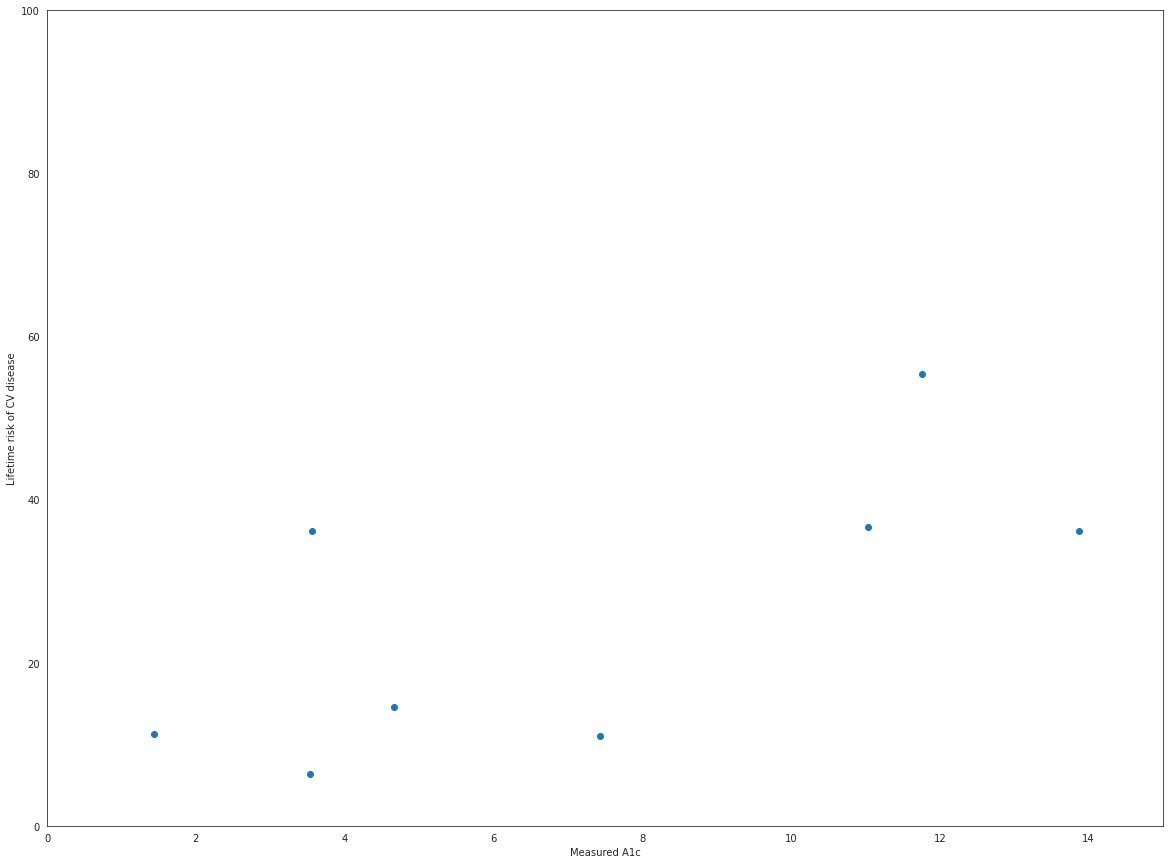

In [52]:

def get_our_data(slope,noise=20,num_pts = 10):
  # the ground truth
  
  # The data we (simulated) collected from patients
  exp_1_a1c = np.random.uniform(0,15,size=(num_pts,1))
  exp_1_lrcv = slope * exp_1_a1c + np.random.normal(0,noise,size=(num_pts,1))

  x = exp_1_a1c.reshape(-1,1)
  y = exp_1_lrcv.reshape(-1,1)

  return x,y,slope

relationship_factor = 4
exp_1_a1c,exp_1_lrcv,slope = get_our_data(slope=relationship_factor)

plot_data(exp_1_a1c,exp_1_lrcv)

reg = LinearRegression(fit_intercept=False).fit(exp_1_a1c, exp_1_lrcv)
reg.score(exp_1_a1c, exp_1_lrcv)
slope_estimate = reg.coef_[0,0]
print('Regression slope is ' + str(reg.coef_[0,0]))

How close are we to the true slope, which we set above at 4 ?


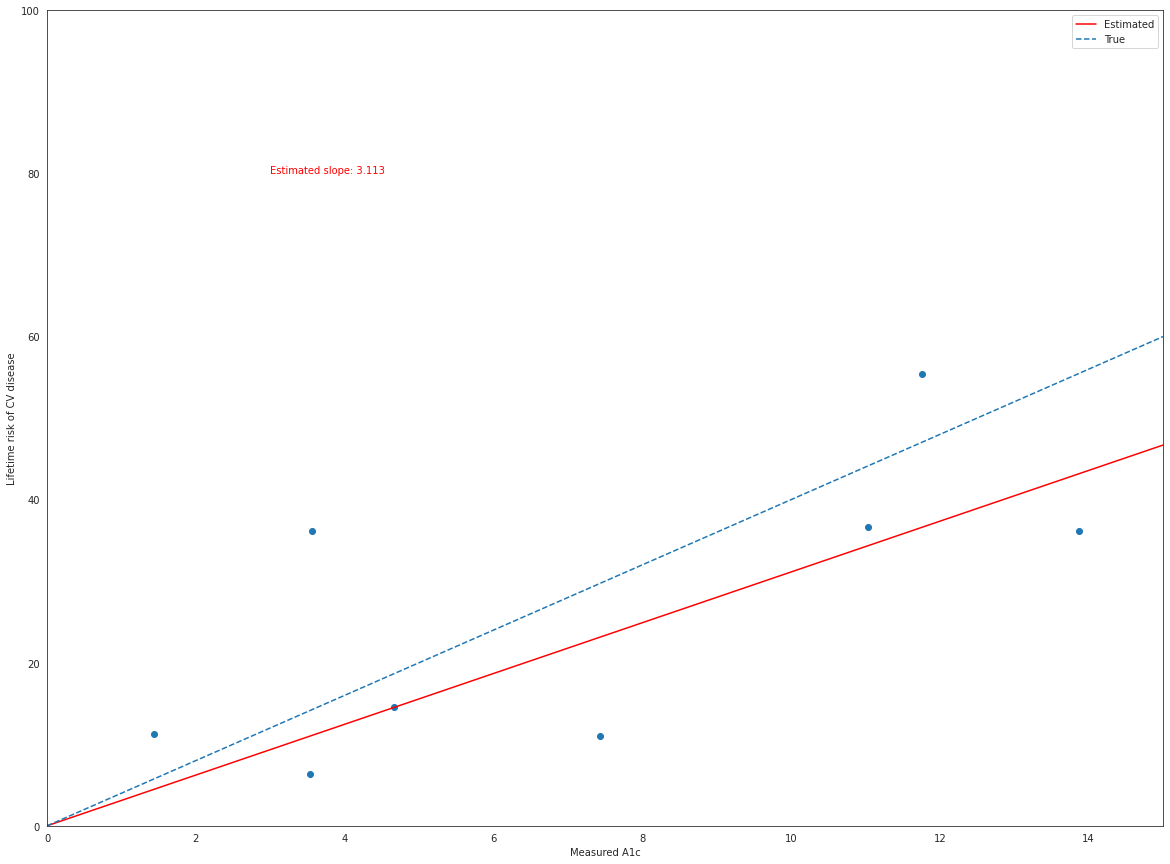

In [53]:
plot_data(exp_1_a1c,exp_1_lrcv)

#Now let's plot the lines that we think link our variables
x_fix = np.linspace(0,15,100)
plt.plot(x_fix,slope_estimate * x_fix + reg.intercept_,'red')
plt.text(3,80,'Estimated slope: ' + str(np.round(slope_estimate,4)),color='red')
plt.plot(x_fix,slope * x_fix,'--')
plt.legend({'True','Estimated'})

print("How close are we to the true slope, which we set above at " + str(np.round(slope,4)) + " ?")

The goal in any linear regression is to *figure out* what the true conversion-factor is using the *data*.

What we did here was take data from our (simulated) patients and fit a line between the datapoints to see if we could *infer* the true relationship between A1c and blood glucose. 
Turns out we can!
Even if it's not perfect, the linear regression approach let us see that there's an *association* between the two variable.


## Signal-to-noise ratio: Adjusting the slope

Next we're going to adjust the slope of our line, or *how strong the relationship between the two variables is* and see how this affects our ability to do a simple regression.


In [54]:
widg = interactive(simple_eg,slope=(0.0,10.0,0.05),noise=(0.0,25.0,1.0),samples=(2,200,1))
display(widg)

interactive(children=(FloatSlider(value=1.0, description='slope', max=10.0, step=0.05), FloatSlider(value=0.0,…

"Slope" is like the strength of the relationship.
"Noise" is the interference that we typically address by collecting a large sample size.

Try it our yourself!
Fix the slope to something like 1.0, then increase the noise to 15.0 while keeping the samples to ~5.
See what happens to your regression line.

Then, move just the slope up to 10 and see what happens to the regression line.

This is similar to a 'power analysis' where you figure out how many samples you need to be able to confidently say "y is related to x, even though there is noise".


### Signal to noise (extra)
Anytime you measure something, part of it is **signal** (the thing you care about), and part of it is **noise** (the things that get in the way).
When we design an experiment we try to remove as much noise as possible so that we're pretty much measuring just signal.

The *signal-to-noise* ratio is an important concept because it reflects how hard/expensive a scientific study will be.
This basically translates to "how big of an effect does my independent variable have on my dependent variable compared to noise?"
It's analogous to a 'power analysis', but it's actually a more flexible concept.

## Three-dimensional regression

What if we've got more than one independent variable?
Imagine we're trying to study if insulin dose and amount of sugar we just ate relate to the blood glucose in 10 minutes.

This type of question is where we start to really see where ML becomes a very powerful research tool.

The variables we're going to look at are related this way:
$ y = 0.2 \cdot x + 10 \cdot w$

---

#### Interactive Example
If we were doing the standard approach, we'd focus on x (independent variable) and y (dependent variable) while keeping w constant.


In [55]:
from mpl_toolkits import mplot3d
import pandas
from pandas import DataFrame
import plotly.express as px

model = np.array([0.2,2]).reshape(-1,1)

noise_slider = widgets.FloatSlider(min=0.0,max=10.0,description="Noise")
display(noise_slider)


FloatSlider(value=0.0, description='Noise', max=10.0)

In [56]:
#If you edit the noise slider, please re-run this cell to re-plot
# TODO Plane
def run_3d(noise):
  pt_num = 100
  x = np.random.uniform(-10,10,size=(pt_num,2))
  y = np.dot(x,model)
  y += np.random.normal(0,noise,size=y.shape)
  data = np.hstack((x,y))
  dats = {'x':data[:,0].squeeze(),'w':data[:,1].squeeze(),'y':data[:,2].squeeze()}
  df = DataFrame(data=dats)

  fig = px.scatter_3d(df, x='x', y='w', z='y',width=1200, height=1200)
  view_range=[-10,10]
  fig.update_layout(scene=dict(xaxis=dict(range=view_range),yaxis=dict(range=view_range),zaxis=dict(range=view_range),aspectmode="cube"))
  fig['layout'].update(width=700, height=700, autosize=False)
  fig.show()

  model_3d = LinearRegression(fit_intercept=True).fit(x, y)
  model_3d.score(x, y) #This gives us a 'score' that tells us how well the model did

  return model_3d.coef_

model_estimate = run_3d(noise=noise_slider.value)
print('Estimated slope is ' + str(model_estimate))

Estimated slope is [[0.2 2. ]]
